# Transmission Spectra for Terrestrial Planets


This tutorial covers how to make model transmission spectra for a terrestrial, Earth-like, exoplanet. We will using atmospheric models of TRAPPIST-1e from [Lin et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.3562L/abstract). The functions from this tutorial can also be used to make a transmission spectrum from any externally computed 1D atmospheric temperature and chemical profiles.

First, let's provide the host star and planet properties. Note that for a rocky planet it is more convient to specify radii and masses in terms of Earth units ($R_{\rm{Earth}}$ and $M_{\rm{Earth}}$).

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_E, M_E

#***** Define stellar properties *****#

R_s = 0.11697*R_Sun   # Stellar radius (m)
T_s = 2559.0          # Stellar effective temperature (K)
Met_s = 0.04          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 5.21        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'TRAPPIST-1e'  # Planet name used for plots, output files etc.

R_p = 0.917985*R_E     # Planetary radius (m)
M_p = 0.6356*M_E       # Planetary mass (kg)
T_eq = 255.0           # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

### Reading an Atmospheric Model

We have provided two pre-computed model atmospheres for TRAPPIST-1e:

* A 'Modern Earth' scenario.
* An 'Archean Earth' scenario.

Both atmosphere models were computed by the 1D self-consistent equilibrium code Exo-Prime2 (see [Lin et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.3562L/abstract) for details). Note that the molecular abundances for each scenario are calculated self-consistently with a TRAPPIST-1 stellar spectrun, so they differ somewhat from the abundances for the present day and ancient Earth.

For the purposes of this tutorial, we have placed the models in the POSEIDON reference data folder: ``POSEIDON/reference_data/models/TRAPPIST-1e/``

Each model has two files: (i) a pressure-temperature (P-T) profile file; and (ii) a mixing ratio / chemical composition file.

We'll see how to read these files in a moment.

First, let's define a POSEIDON model object. When specifying this model, we'll flag that both the P-T profile and mixing ratios come from external files (rather than the user providing atmospheric parameters as in previous tutorials).


In [2]:
from POSEIDON.core import define_model
import numpy as np

#***** Define models *****#

model_name_1 = 'Modern_Earth'   # First model
model_name_2 = 'Archean_Earth'  # Second model

bulk_species = ['N2']                                      # For terrestrial planets, only the single most abundant gas should be provided here
param_species = ['O2', 'CO2', 'CH4', 'H2O', 'O3', 'N2O']   # Less abundant chemical species (same species for both model)

# Create the model objects
model_1 = define_model(model_name_1, bulk_species, param_species, 
                       PT_profile = 'file_read', X_profile = 'file_read',
                       surface = True)
model_2 = define_model(model_name_2, bulk_species, param_species, 
                       PT_profile = 'file_read', X_profile = 'file_read',
                       surface = True)

#***** Create model pressure grid (same for both models) *****#

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 10.0      # 10 bar (you can extend the atmosphere deeper than the surface)
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Add the surface pressure
P_surf = 1.0      # Effectively acts as a cloud deck opaque at all wavelengths

# Specify the reference pressure and radius
P_ref = P_surf    # We'll set the reference pressure at the surface
R_p_ref = R_p     # Radius at reference pressure

#### Reading a P-T profile file

Now let's open one of the P-T files in a text editor to examine its structure. Here are the first 10 lines of the Modern Earth file:

![PT_file_preview](../../_static/notebook_images/TRAPPIST-1e_Modern_Earth_PT.png)

The format of input files can vary wildly (a known hazard of working with theorists). Nevertheless, POSEIDON has functions that can read in many different file formats and interpolate the P-T and chemical profiles onto the model pressure grid.

Since we're only actually interested in the second and third columns in this file, we'll tell POSEIDON to skip the first line (the header) and which columns contain the pressure and temperature.

In [3]:
from POSEIDON.utility import read_PT_file

# Specify location of the P-T profile file
PT_file_dir = 'Tutorial/TRAPPIST-1e'
PT_file_name_1 = 'TRAPPIST-1e_1.0bar_100xCO2_Modern_PT.txt'
PT_file_name_2 = 'TRAPPIST-1e_1.0bar_100xCO2_Archean_PT.txt'

# Read the P-T profile files
T_Modern = read_PT_file(PT_file_dir, PT_file_name_1, P, skiprows = 1,
                        P_column = 2, T_column = 3)
T_Archean = read_PT_file(PT_file_dir, PT_file_name_2, P, skiprows = 1,
                        P_column = 2, T_column = 3)

#### Reading a chemical abundance profile file

Similarly, here are the first 10 lines of the modern Earth chemical abundance file:

![chem_file_preview](../../_static/notebook_images/TRAPPIST-1e_Modern_Earth_chem.png)



To read in this file, we need to tell POSEIDON which chemical species are contained in the file. The function below assumes that the first column of the input file is pressure, followed by each of the species you provide in the list 'chem_species_file'.

In [4]:
from POSEIDON.utility import read_chem_file

# Specify location of the composition file
chem_file_dir = 'Tutorial/TRAPPIST-1e'
chem_file_name_1 = 'TRAPPIST-1e_1.0bar_100xCO2_Modern_chem.txt'
chem_file_name_2 = 'TRAPPIST-1e_1.0bar_100xCO2_Archean_chem.txt'

chem_species_file = ['N2', 'O2', 'O3', 'H2O', 'CH4', 'N2O', 'CO2', 'CO']  # Same ordering for both files

# Read the composition files
X_Modern = read_chem_file(chem_file_dir, chem_file_name_1, P, chem_species_file, 
                          chem_species_model = model_1['chemical_species'], 
                          skiprows = 1)
X_Archean = read_chem_file(chem_file_dir, chem_file_name_2, P, chem_species_file, 
                           chem_species_model = model_2['chemical_species'], 
                           skiprows = 1)

If a species is included in the input file but not in the POSEIDON model (e.g. $\rm{CO}$, since we didn't include it in 'param_species' above), then the abundance of that species will not be read. Similarly, any model species not included in the input file will be assumed to have zero abundance throughout the atmosphere. 

#### Creating the model atmosphere

We can now provide the temperature and mixing ratio profiles to the usual function to generate our two atmospheres.

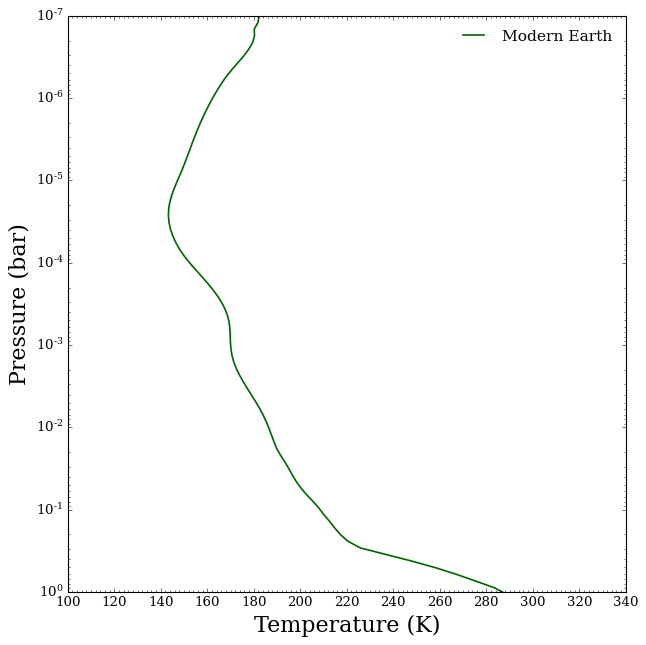

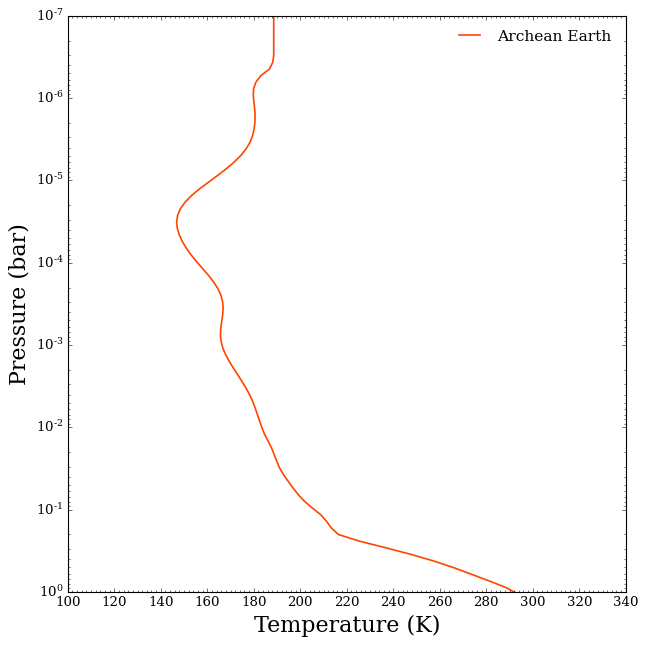

In [5]:
from POSEIDON.core import make_atmosphere
from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

# Generate the atmospheres
atmosphere_1 = make_atmosphere(planet, model_1, P, P_ref, R_p_ref, 
                               T_input = T_Modern, X_input = X_Modern,    # Provide T and X directly here
                               P_surf = P_surf)                           # Also provide the surface pressure 
atmosphere_2 = make_atmosphere(planet, model_2, P, P_ref, R_p_ref, 
                               T_input = T_Archean, X_input = X_Archean,    # Provide T and X directly here
                               P_surf = P_surf)                             # Also provide the surface pressure

#***** Produce plots of atmospheric properties *****#

# Compare the P-T profiles first
fig_PT_1 = plot_PT(planet, model_1, atmosphere_1, T_min = 100, T_max = 340,       # This demonstrates several plot customisation options
                   log_P_max = np.log10(P_surf), PT_label = 'Modern Earth',
                   legend_location = 'upper right', colour = 'darkgreen')
fig_PT_2 = plot_PT(planet, model_2, atmosphere_2, T_min = 100, T_max = 340, 
                   log_P_max = np.log10(P_surf), PT_label = 'Archean Earth',
                   legend_location = 'upper right', colour = 'orangered')

#fig_geom_1 = plot_geometry(planet, star, model_1, atmosphere_1)   # This figure looks a little boring for a (tiny) Earth-like atmosphere!

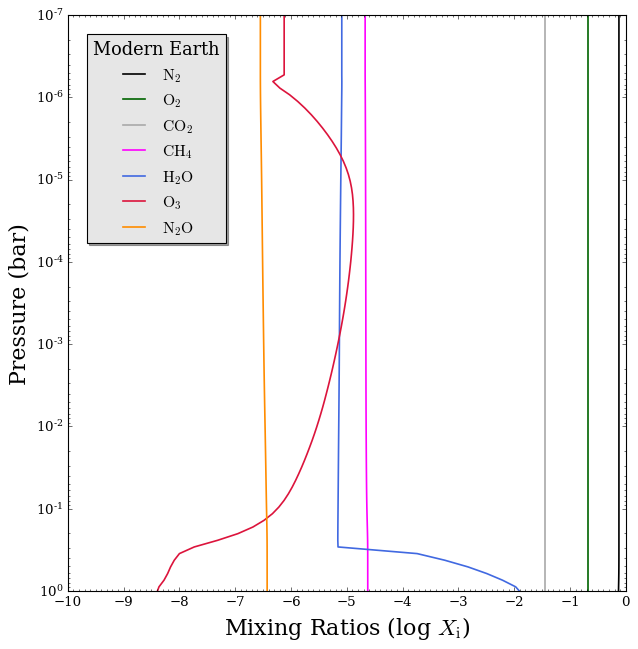

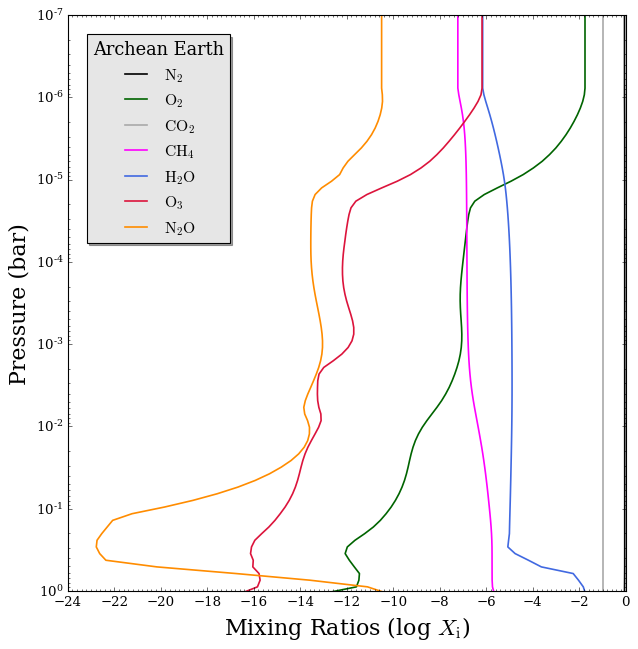

In [6]:
# Compare the mixing ratio profiles
fig_chem_1 = plot_chem(planet, model_1, atmosphere_1, log_P_max = np.log10(P_surf),
                       legend_title = 'Modern Earth', legend_location = 'upper left',
                       colour_list = ['black', 'darkgreen', 'darkgrey', 'magenta',   # Here you can override the default colours
                                      'royalblue', 'crimson', 'darkorange'])
fig_chem_2 = plot_chem(planet, model_2, atmosphere_2, log_P_max = np.log10(P_surf),
                       legend_title = 'Archean Earth', legend_location = 'upper left',
                       colour_list = ['black', 'darkgreen', 'darkgrey', 'magenta',
                                       'royalblue', 'crimson', 'darkorange'])

We see that the most striking difference between the models is that the Archean Earth has much lower abundances for many of the oxygen-bearing species ($\rm{O}_2$, $\rm{O}_3$, and $\rm{N}_2 \rm{O}$). This makes sense, since the Archean scenario corresponds to a time before the Earth's great oxidation event.

### Computing Transmission Spectra of TRAPPIST-1e

With our atmospheres created, we can now compute the corresponding transmission spectra for TRAPPIST-1e.

#### Terrestrial planet cross sections

For terrestrial planets, POSEIDON includes a seperate 'temperate' opacity database. These temperate cross sections (made from HITRAN line lists) are specifically optimised for improved accuracy when computing spectra for low temperature atmospheres ($T \lesssim 400 \, \rm{K}$). The opacity database (either the default 'High-T' or 'Temperate') is specified via the 'opacity_database' variable.

In [7]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Wavelength grid *****#
 
wl_min = 0.6      # Minimum wavelength (um)
wl_max = 14.0     # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # 100 K lower limit covers the TRAPPIST-1e P-T profile
T_fine_max = 300     # 300 K upper limit covers the TRAPPIST-1e P-T profile
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 0.0    # 1 bar is the surface pressure, so no need to go deeper
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Create opacity object (both models share the same molecules, so we only need one)
opac = read_opacities(model_1, wl, opacity_treatment, T_fine, log_P_fine,
                      opacity_database = 'Temperate')

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
N2 done
O2 done
CO2 done
CH4 done
H2O done
O3 done
N2O done
Opacity pre-interpolation complete.


#### Comparing TRAPPIST-1e model spectra

Finally, let's generate and compare the Modern Earth and Archean Earth transmission spectra.

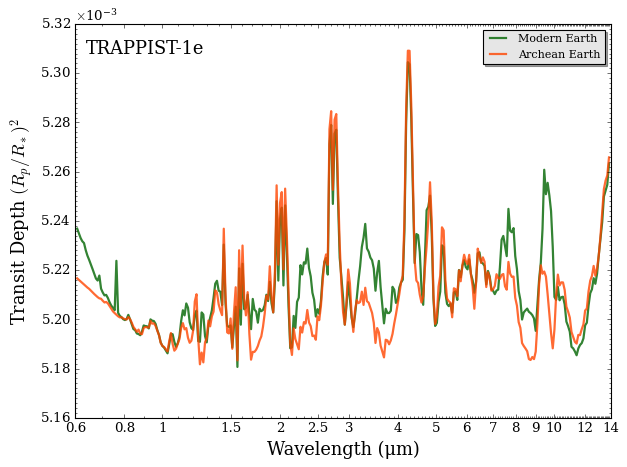

In [8]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our first transmission spectrum
spectrum_Modern = compute_spectrum(planet, star, model_1, atmosphere_1, opac, wl,
                                   spectrum_type = 'transmission')
spectrum_Archean = compute_spectrum(planet, star, model_2, atmosphere_2, opac, wl,
                                    spectrum_type = 'transmission')

spectra = []   # Empty plot collection

# Add the two model spectra to the plot collection object
spectra = plot_collection(spectrum_Modern, wl, collection = spectra)
spectra = plot_collection(spectrum_Archean, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        transit_depth_min = 5.16e-3, transit_depth_max = 5.32e-3,
                        spectra_labels = ['Modern Earth', 'Archean Earth'],
                        colour_list = ['darkgreen', 'orangered'])

And there we have it!

Interestingly, many of the spectral features seen only in the Modern Earth scenario are attributable to life (e.g. the $\rm{O}_2$ and $\rm{O}_3$ features seen at short wavelengths). 